In [1]:
!pip install transformers
!pip install keras_tuner
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [59]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import keras_tuner
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, RNN, SimpleRNN, GRU
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import utils

Using GPU if available

In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [60]:
df = pd.read_csv("subtaskA_train.csv")

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1842 entries, 0 to 1841
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              1842 non-null   int64 
 1   comment_text    1842 non-null   object
 2   conspiratorial  1842 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 43.3+ KB


In [110]:
df.head()

,Id,comment_text,conspiratorial
0,0,⚡Se non ci fossero soldati non ci sarebbero gu...,0
1,1,"21/08/21]( [PRE-PRINT]\n\n📄__ ""Shedding of Inf...",1
2,2,PAURA E DELIRIO ALLA CNN: IL MINISTERO DELLA V...,1
3,3,L'Aspirina non aumenta la sopravvivenza dei pa...,0
4,4,L'Italia non puo' dare armi lo vieta la Costit...,0


Removing emojis

In [129]:
df["comment_text"] = df["comment_text"].map(remove_emojis)

<Axes: >

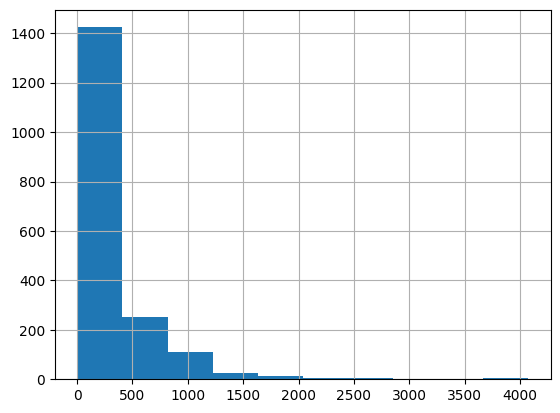

In [10]:
df["comment_text"].map(len).hist()

<Axes: >

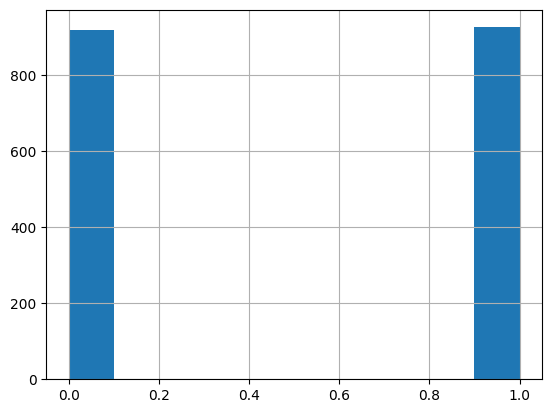

In [11]:
df["conspiratorial"].hist()

# Pre processing

## Building train and test set

In [131]:
X = df["comment_text"]
y = df["conspiratorial"]

Assigning 25% of the data to the test set, specifying (using the parameter _stratify_) that the dataset have to be balanced regarding the label "conspirational"

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.25, random_state = 10)

# Model training

In [133]:
tfhub_handle_encoder = "https://tfhub.dev/google/universal-sentence-encoder-multilingual/3"
tfhub_handle_preprocess = "https://tfhub.dev/google/universal-sentence-encoder-multilingual/3"

In [134]:
def build_model_with_hp(lstm_units, l1_units, l2_units, l3_units, learning_rate, epsilon):
    # defining inputs
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

    # defining preprocessing
    #preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')

    # defining encoder
    #encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name='text_encoder')

    # defining outputs
    #outputs = encoder(encoder_inputs)
    net = encoder(text_input)
    #net = outputs['pooled_output']

    # Reshape net to add a time step dimension
    net = tf.expand_dims(net, axis=1)

    net = LSTM(
        units =lstm_units,
        dropout=0.1
    )(net)

    # FULLY CONNECTED LAYERS

    net = tf.keras.layers.Dense(
        units = l1_units,
        activation="relu")(net)

    net = Dropout(rate=0.1)(net)

    net = tf.keras.layers.Dense(
        units = l2_units,
        activation="relu")(net)

    net = Dropout(rate=0.1)(net)

    net = tf.keras.layers.Dense(
        units = l3_units,
        activation="relu")(net)

    net = Dropout(rate=0.1)(net)

    # OUTPUT LAYER
    net = tf.keras.layers.Dense(1, activation="sigmoid", name='classifier')(net)

    model = tf.keras.Model(text_input, net)

    optimizer = Adam(
        learning_rate = learning_rate,
        epsilon = epsilon,
        clipnorm = 0.1
    )

    model.compile(
        optimizer=optimizer,
        loss = 'binary_crossentropy',
        metrics = 'accuracy'
    )

    return model

def build_classifier_model(hp):
    lstm_units = hp.Int('lstm_units', min_value=4, max_value=10, step=1)
    l1_units = hp.Int('l1_units', min_value=5, max_value=40, step=5)
    l2_units = hp.Int('l2_units', min_value=5, max_value=40, step=5)
    l3_units = hp.Int('l3_units', min_value=5, max_value=40, step=5)
    learning_rate = hp.Choice('learning_rate', values=[1e-3]),
    epsilon = hp.Choice('epsilon', values=[1e-7])

    return build_model_with_hp(lstm_units, l1_units, l2_units, l3_units, learning_rate, epsilon)

## Performing a random search of the hyperparameters

In [135]:
tuner = kt.RandomSearch(
    hypermodel=build_classifier_model,
    max_trials=10,
    objective='val_accuracy',
    overwrite=True
)

In [136]:
print(f'Training model with {tfhub_handle_encoder}')
tuner.search(
    x = X_train,
    y = y_train,
    epochs = 200,
    validation_split = 0.25,
    callbacks = [
        EarlyStopping(monitor='val_accuracy' ,mode='max', patience=3,verbose=False,restore_best_weights=True)
    ]
)

Trial 10 Complete [00h 00m 53s]
val_accuracy: 0.7716763019561768

Best val_accuracy So Far: 0.7890173196792603
Total elapsed time: 00h 08m 42s


In [137]:
tuner.results_summary(5)

Results summary
Results in ./untitled_project
Showing 5 best trials
Objective(name="val_accuracy", direction="max")

Trial 06 summary
Hyperparameters:
lstm_units: 7
l1_units: 25
l2_units: 5
l3_units: 10
learning_rate: 0.001
epsilon: 1e-07
Score: 0.7890173196792603

Trial 09 summary
Hyperparameters:
lstm_units: 9
l1_units: 20
l2_units: 15
l3_units: 30
learning_rate: 0.001
epsilon: 1e-07
Score: 0.7716763019561768

Trial 01 summary
Hyperparameters:
lstm_units: 10
l1_units: 35
l2_units: 30
l3_units: 25
learning_rate: 0.001
epsilon: 1e-07
Score: 0.7687861323356628

Trial 03 summary
Hyperparameters:
lstm_units: 9
l1_units: 35
l2_units: 30
l3_units: 25
learning_rate: 0.001
epsilon: 1e-07
Score: 0.7687861323356628

Trial 07 summary
Hyperparameters:
lstm_units: 7
l1_units: 20
l2_units: 25
l3_units: 10
learning_rate: 0.001
epsilon: 1e-07
Score: 0.7687861323356628


# Final phase: retrain and test

## Retrain on training and validation

Training the model on the best hyperparams found by the random search

In [138]:
best_hyperparams = tuner.get_best_hyperparameters(1)[0]

final_model = tuner.hypermodel.build(best_hyperparams)

In [139]:
%%time
print(f'Training model with {tfhub_handle_encoder}')
history = final_model.fit(
    x = X_train,
    y = y_train,
    epochs=200,
    validation_split = 0,
    batch_size = 32,
    callbacks= [
      EarlyStopping( monitor='accuracy' ,mode='max', patience=3,verbose=False,restore_best_weights=True)
    ]
)


Training model with https://tfhub.dev/google/universal-sentence-encoder-multilingual/3
Epoch 1/200
44/44 [==============================] - 13s 48ms/step - loss: 0.6926 - accuracy: 0.4960
Epoch 2/200
44/44 [==============================] - 1s 29ms/step - loss: 0.6819 - accuracy: 0.5286
Epoch 3/200
44/44 [==============================] - 1s 28ms/step - loss: 0.6468 - accuracy: 0.6698
Epoch 4/200
44/44 [==============================] - 1s 28ms/step - loss: 0.5850 - accuracy: 0.7393
Epoch 5/200
44/44 [==============================] - 1s 28ms/step - loss: 0.5172 - accuracy: 0.7705
Epoch 6/200
44/44 [==============================] - 1s 28ms/step - loss: 0.4878 - accuracy: 0.7770
Epoch 7/200
44/44 [==============================] - 1s 27ms/step - loss: 0.4569 - accuracy: 0.7886
Epoch 8/200
44/44 [==============================] - 1s 27ms/step - loss: 0.4441 - accuracy: 0.7900
Epoch 9/200
44/44 [==============================] - 1s 34ms/step - loss: 0.4364 - accuracy: 0.7929
Epoch 10/200

In [142]:
final_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None,)]                 0         
                                                                 
 BERT_encoder (KerasLayer)   (None, 512)               68927232  
                                                                 
 tf.expand_dims_1 (TFOpLambd  (None, 1, 512)           0         
 a)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 7)                 14560     
                                                                 
 dense_3 (Dense)             (None, 25)                200       
                                                                 
 dropout_3 (Dropout)         (None, 25)                0         
                                                           

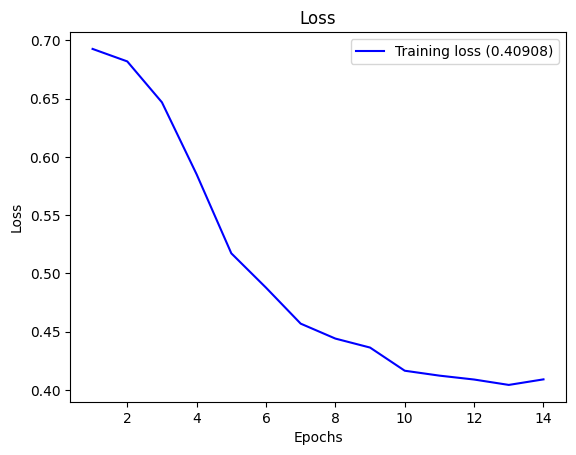

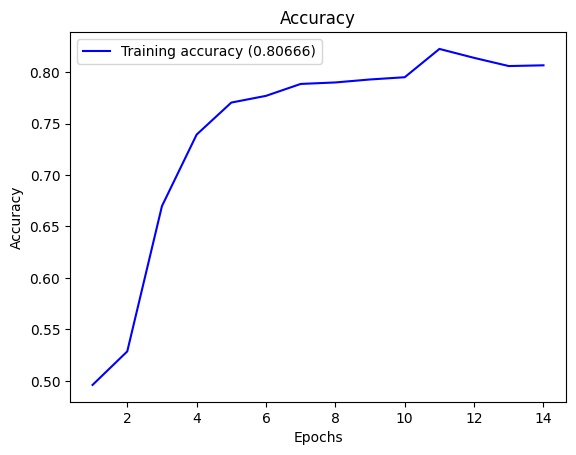

In [140]:
plot_history(history)

## Predict on test set

In [141]:
_ = final_model.evaluate(
    x=X_test,
    y=y_test,
    batch_size=32
)

15/15 [==============================] - 2s 22ms/step - loss: 0.4453 - accuracy: 0.7722
